### 환경 설정

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False 

### 데이터 준비

In [3]:
import pandas as pd
data = pd.read_csv("../../데이터/기업월별평점.csv", encoding = "euc-kr")
display(data.head())

,기업,날짜,전체평점,승진기회및가능성,복지및급여,업무와삶의균형,사내문화,경영진
0,CJ제일제당,2014. 04,3.400000,3.733333,3.066667,2.333333,3.400000,3.000000
1,CJ제일제당,2014. 05,3.200000,3.300000,2.800000,3.000000,3.400000,2.900000
2,CJ제일제당,2014. 06,2.913043,3.130435,2.913043,2.260870,3.173913,2.608696
3,CJ제일제당,2014. 07,3.058824,3.352941,2.470588,2.235294,3.294118,2.764706
4,CJ제일제당,2014. 08,2.800000,3.400000,2.800000,2.400000,3.000000,2.800000


#### 연도와 월 컬럼 생성

In [4]:
data[['연도', '월']] = data['날짜'].str.split('. ', expand = True).astype(int)

#### 주가 데이터와 병합

In [5]:
import numpy as np
import os

path = "../../데이터/주가데이터/"

total_M_sp_data = pd.DataFrame()
for stock_name in data['기업'].unique():
    # 주가 데이터 불러오기 
    if stock_name + ".csv" in os.listdir(path):
        sp_data = pd.read_csv(path + stock_name + ".csv", parse_dates = ["Date"])
    else:
        data = data.loc[data['기업'] != stock_name]
        continue
    
    # 연도와 월 추출
    sp_data["연도"] = sp_data["Date"].dt.year
    sp_data["월"] = sp_data["Date"].dt.month
    
    # 월별 평균가격, 월말가격 계산
    M_sp_data = sp_data.groupby(['연도', '월'])['Close'].agg([np.mean,
                                                              lambda x:x.iloc[-1]])
    M_sp_data.reset_index(inplace = True)
    M_sp_data.columns = ["연도", "월", "평균가격", "월말가격"]
    M_sp_data["차월말가격"] = np.nan
    M_sp_data["차월말가격"].iloc[:-1] = M_sp_data["월말가격"].values[1:]
    M_sp_data["기업"] = stock_name

    # 데이터 병합
    total_M_sp_data = pd.concat([total_M_sp_data, M_sp_data],
                                axis = 0, ignore_index = True)

In [6]:
data = pd.merge(total_M_sp_data, data, on = ["연도", "월", "기업"])
display(data.head())

,연도,월,평균가격,월말가격,차월말가격,기업,날짜,전체평점,승진기회및가능성,복지및급여,업무와삶의균형,사내문화,경영진
0,2014,4,295113.636364,310000,330000.0,CJ제일제당,2014. 04,3.400000,3.733333,3.066667,2.333333,3.400000,3.000000
1,2014,5,324947.368421,330000,344500.0,CJ제일제당,2014. 05,3.200000,3.300000,2.800000,3.000000,3.400000,2.900000
2,2014,6,341315.789474,344500,333000.0,CJ제일제당,2014. 06,2.913043,3.130435,2.913043,2.260870,3.173913,2.608696
3,2014,7,343717.391304,333000,378000.0,CJ제일제당,2014. 07,3.058824,3.352941,2.470588,2.235294,3.294118,2.764706
4,2014,8,360950.000000,378000,387500.0,CJ제일제당,2014. 08,2.800000,3.400000,2.800000,2.400000,3.000000,2.800000


### 주가와 평점 간 관계 분석

#### 상관관계 분석

In [7]:
corr_result = []
cols = ["전체평점", "승진기회및가능성", "복지및급여", "업무와삶의균형", "사내문화", "경영진"]
for corp in data['기업'].unique():
    corp_data = data.loc[data['기업'] == corp]
    record = corp_data.corr().loc['평균가격', cols].values
    corr_result.append(record)
corr_result = pd.DataFrame(corr_result, columns = cols)

In [8]:
display(corr_result.describe().round(3))

,전체평점,승진기회및가능성,복지및급여,업무와삶의균형,사내문화,경영진
count,45.000,45.000,45.000,45.000,45.000,45.000
mean,0.021,-0.019,0.018,-0.058,-0.018,0.021
std,0.279,0.204,0.267,0.336,0.224,0.270
min,-0.989,-0.623,-0.623,-0.782,-0.623,-0.782
25%,-0.111,-0.112,-0.186,-0.273,-0.099,-0.116
50%,0.026,-0.019,0.066,-0.063,-0.020,0.010
75%,0.164,0.143,0.178,0.159,0.080,0.159
max,0.755,0.294,0.519,0.782,0.726,0.593


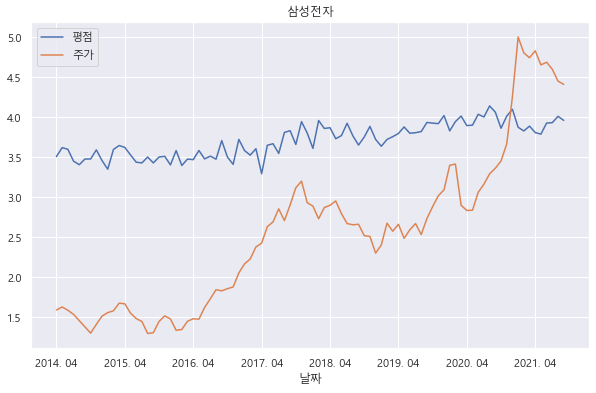

In [9]:
plt.figure(figsize = (10 ,6))
x = data.loc[data['기업'] == "삼성전자", '날짜'].values
y1 = data.loc[data['기업'] == "삼성전자", '전체평점'].values
y2 = data.loc[data['기업'] == "삼성전자", '평균가격'].values
y2 = y2 / max(y2) * 5

xticks_range = np.arange(0, sum(data['기업'] == "삼성전자"), 12)
plt.xticks(xticks_range, x[xticks_range])
plt.title("삼성전자")
plt.xlabel("날짜")
plt.plot(x, y1, label = "평점")
plt.plot(x, y2, label = "주가")
plt.legend()

### 동일가중 교체 매매에 따른 수익 비교

In [10]:
def make_group(rating):
    if rating <= 3.0:
        return 1
    elif rating <= 3.3:
        return 2
    elif rating <= 3.5:
        return 3
    elif rating <= 4.0:
        return 4
    else:
        return 5

In [11]:
data['수익률'] = (data['차월말가격'] - data['월말가격']) / data['월말가격'] * 100
data.dropna(inplace = True)

In [12]:
def calc_ror_using_eqw_str(data, r_col): 
    group_list = data[r_col].apply(make_group)
    ym_list = data[['연도', '월']].sort_values(['연도', '월']).drop_duplicates().values
    result = []
    for year, month in ym_list:
        ym_data = data.loc[(data["연도"] == year) & (data["월"] == month)]
        for group in range(1, 6):
            group_data = ym_data.loc[group_list == group]
            if len(group_data) == 0:
                result.append([year, month, group, 0])
            else:
                ror_list = group_data['수익률']
                inve_per_stock = 10**8 / len(ror_list)
                profit = (inve_per_stock * ror_list / 100).sum()
                profit_ratio = profit / 10 ** 8 * 100
                result.append([year, month, group, profit_ratio])

    result = pd.DataFrame(result, columns = ["연도", "월", "그룹", "수익률"])
    return result

In [13]:
def visualize_result(result):
    ym_list = result[['연도', '월']].sort_values(['연도', '월']).drop_duplicates().values
    plt.figure(figsize = (14, 5))
    for group in range(1, 6):
        plt.plot(result.loc[result['그룹'] == group, '수익률'].values, label = group)
    xticks_range = np.arange(0, len(ym_list), 12)
    plt.xticks(xticks_range, ym_list[xticks_range, 0])
    plt.ylabel("수익률")
    plt.legend()

#### 전체평점

In [14]:
r_col = "전체평점"
result = calc_ror_using_eqw_str(data, r_col)

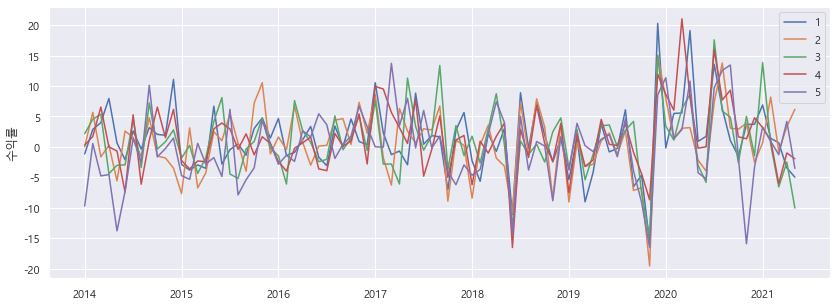

In [15]:
visualize_result(result)

In [16]:
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,1.244,5.452,-15.753,-1.562,1.047,3.665,20.279
2,89.0,0.722,5.483,-19.579,-1.860,0.758,3.544,15.083
3,89.0,0.929,5.582,-14.962,-2.596,0.441,4.175,17.571
4,89.0,1.267,5.337,-16.551,-1.966,0.952,3.885,21.025
5,89.0,-0.165,6.059,-16.567,-3.815,0.000,3.318,13.711


#### 승진 기회 및 가능성

In [17]:
r_col = "승진기회및가능성"
result = calc_ror_using_eqw_str(data, r_col)

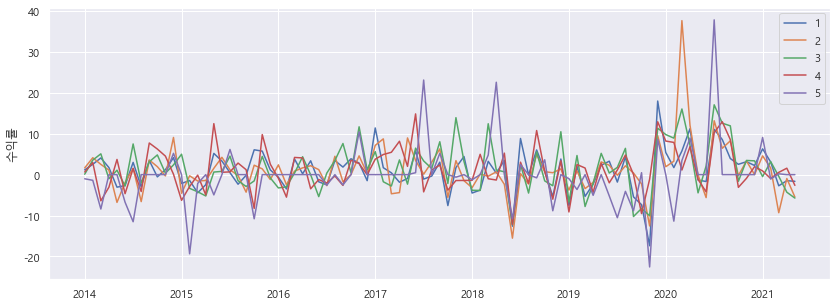

In [18]:
visualize_result(result)

In [19]:
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.974,5.018,-17.390,-1.821,1.211,3.494,17.994
2,89.0,1.043,6.094,-15.536,-1.744,0.727,3.111,37.652
3,89.0,1.575,5.878,-12.252,-2.328,0.799,4.818,17.075
4,89.0,1.108,5.226,-12.183,-2.055,0.786,3.772,14.851
5,89.0,-0.161,7.436,-22.573,-1.013,0.000,0.000,37.849


#### 복지 및 급여

In [20]:
r_col = "복지및급여"
result = calc_ror_using_eqw_str(data, r_col)

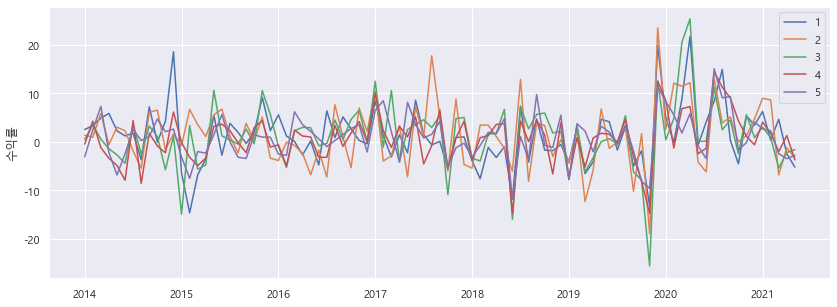

In [21]:
visualize_result(result)

In [22]:
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,1.221,6.120,-14.647,-2.468,0.908,4.662,21.760
2,89.0,1.307,6.572,-18.920,-3.014,1.110,5.151,23.527
3,89.0,1.166,6.804,-25.617,-1.618,1.201,4.522,25.399
4,89.0,0.584,5.078,-14.807,-2.248,0.896,3.747,14.465
5,89.0,0.939,4.675,-11.828,-2.184,1.088,3.527,15.092


#### 업무와 삶의 균형

In [23]:
r_col = "업무와삶의균형"
result = calc_ror_using_eqw_str(data, r_col)

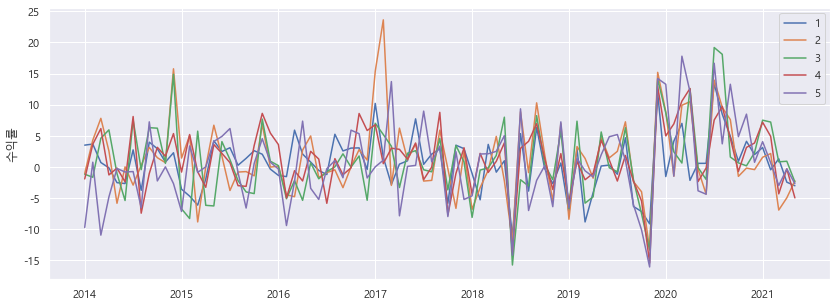

In [24]:
visualize_result(result)

In [25]:
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.673,4.357,-11.203,-1.568,0.766,3.051,13.365
2,89.0,1.359,6.152,-13.242,-2.244,0.096,4.727,23.636
3,89.0,0.954,6.030,-15.780,-2.205,0.362,4.600,19.186
4,89.0,1.237,5.004,-15.460,-1.943,1.254,4.107,12.912
5,89.0,0.489,6.492,-16.093,-2.991,0.073,4.080,17.794


#### 사내 문화

In [26]:
r_col = "사내문화"
result = calc_ror_using_eqw_str(data, r_col)

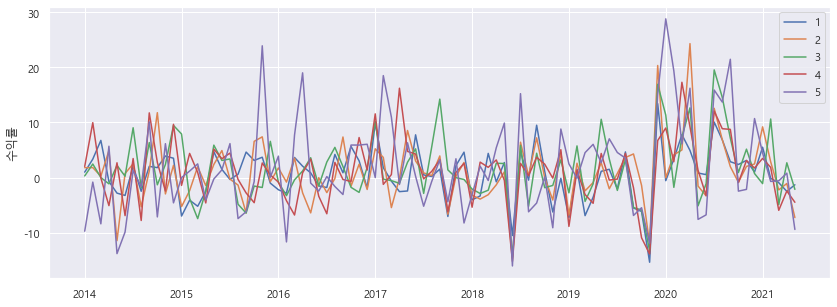

In [27]:
visualize_result(result)

In [28]:
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.615,4.610,-15.381,-2.215,0.869,3.354,13.422
2,89.0,0.901,5.759,-14.671,-2.166,0.358,3.514,24.319
3,89.0,1.536,5.903,-14.411,-1.857,0.293,5.154,19.549
4,89.0,1.053,5.795,-15.219,-2.444,1.327,3.482,17.301
5,89.0,1.870,8.704,-16.055,-4.071,0.177,6.047,28.819


#### 경영진

In [29]:
r_col = "경영진"
result = calc_ror_using_eqw_str(data, r_col)

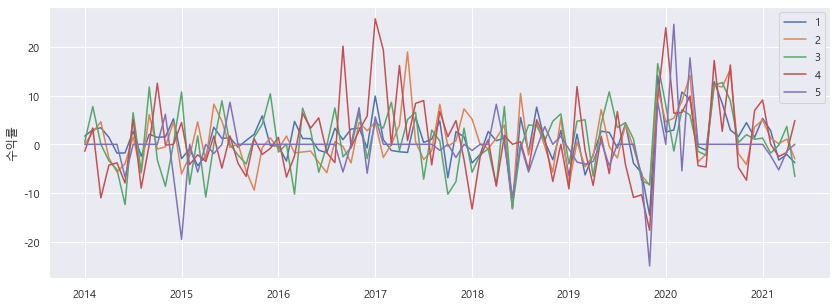

In [30]:
visualize_result(result)

In [34]:
display(result.dropna().groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.931,4.561,-14.522,-1.669,1.212,2.955,14.159
2,89.0,0.930,5.628,-13.155,-2.702,0.000,4.505,18.933
3,89.0,0.889,6.256,-12.934,-2.950,0.687,5.039,16.548
4,89.0,1.033,8.035,-17.607,-4.149,0.000,5.056,25.714
5,89.0,-0.490,5.617,-24.928,-0.980,0.000,0.000,24.598


In [31]:
display(result.groupby('그룹')['수익률'].describe().round(3))

,count,mean,std,min,25%,50%,75%,max
그룹,,,,,,,,
1,89.0,0.931,4.561,-14.522,-1.669,1.212,2.955,14.159
2,89.0,0.930,5.628,-13.155,-2.702,0.000,4.505,18.933
3,89.0,0.889,6.256,-12.934,-2.950,0.687,5.039,16.548
4,89.0,1.033,8.035,-17.607,-4.149,0.000,5.056,25.714
5,89.0,-0.490,5.617,-24.928,-0.980,0.000,0.000,24.598
